<a href="https://colab.research.google.com/github/amadousysada/content-recommendation/blob/main/analyse-exploratoire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import time
init_time = time.time()

import os
import scipy
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import sklearn
print("Versions:")
print(f"{' '*2}- Numpy        =>: {np.__version__}")
print(f"{' '*2}- Pandas   =>: {pd.__version__}")
print(f"{' '*2}- sklearn   =>: {sklearn.__version__}")

Versions:
  - Numpy        =>: 2.0.2
  - Pandas   =>: 2.2.2
  - sklearn   =>: 1.6.1


In [3]:
base_path = "/content/drive/MyDrive/data/p10_content_recommendation"

ARTICLE_EMBEDDINGS_FILE = os.path.join(base_path, "articles_embeddings.pickle")
ARTICLE_METADATA_FILE = os.path.join(base_path, "articles_metadata.csv")
CLICKS_SAMPLES_FILE = os.path.join(base_path, "clicks_sample.csv")
CLICKS_FOLDER_PATH = os.path.join(base_path, "clicks")

In [4]:
print("ARTICLE_EMBEDDINGS_FILE: "+ str(ARTICLE_EMBEDDINGS_FILE))
print("ARTICLE_METADATA_FILE: "+ str(ARTICLE_METADATA_FILE))
print("CLICKS_FOLDER_PATH: "+ str(CLICKS_FOLDER_PATH))

ARTICLE_EMBEDDINGS_FILE: /content/drive/MyDrive/data/p10_content_recommendation/articles_embeddings.pickle
ARTICLE_METADATA_FILE: /content/drive/MyDrive/data/p10_content_recommendation/articles_metadata.csv
CLICKS_FOLDER_PATH: /content/drive/MyDrive/data/p10_content_recommendation/clicks


In [5]:
embeddings = pd.read_pickle(ARTICLE_EMBEDDINGS_FILE)
embeddings.shape

(364047, 250)

In [6]:
articles_metadata = pd.read_csv(ARTICLE_METADATA_FILE)

In [7]:
articles_metadata.head(10)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
5,5,1,1407413929000,0,196
6,6,1,1409896802000,0,203
7,7,1,1412559620000,0,154
8,8,1,1414351550000,0,209
9,9,1,1412526792000,0,181


In [8]:
articles_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB


In [9]:
print(f"Nombre total de category: {len(articles_metadata.category_id.unique())}")

Nombre total de category: 461


In [10]:
clicks_sample = pd.read_csv(CLICKS_SAMPLES_FILE)

In [11]:
clicks_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   user_id              1883 non-null   int64
 1   session_id           1883 non-null   int64
 2   session_start        1883 non-null   int64
 3   session_size         1883 non-null   int64
 4   click_article_id     1883 non-null   int64
 5   click_timestamp      1883 non-null   int64
 6   click_environment    1883 non-null   int64
 7   click_deviceGroup    1883 non-null   int64
 8   click_os             1883 non-null   int64
 9   click_country        1883 non-null   int64
 10  click_region         1883 non-null   int64
 11  click_referrer_type  1883 non-null   int64
dtypes: int64(12)
memory usage: 176.7 KB


In [12]:
clicks_sample.head(10)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
5,2,1506825435299739,1506825435000,2,30970,1506827120575,4,1,17,1,24,2
6,3,1506825442704740,1506825442000,2,236065,1506827536942,4,3,2,1,21,1
7,3,1506825442704740,1506825442000,2,236294,1506827566942,4,3,2,1,21,1
8,4,1506825528135741,1506825528000,2,48915,1506826927593,4,1,17,1,17,1
9,4,1506825528135741,1506825528000,2,44488,1506826957593,4,1,17,1,17,1


In [182]:
clicks_sample.rename(columns={'click_article_id': 'article_id'}, inplace=True)

# Modelisation

In [357]:
clicks_train_df, clicks_test_df = train_test_split(clicks_sample, test_size=0.2, random_state=42)

In [358]:
import random

EVAL_RANDOM_SAMPLE_NON_CLICKED_ARTICLES = 100

def get_articles_clicked(user_id, clicked_df):
    clicked_articles = clicked_df.loc[clicked_df.user_id==user_id, 'article_id'].unique().tolist()
    return clicked_articles

def get_not_clicked_articles_sample(user_id, sample_size, articles_to_ignore, seed=42):
        all_articles = articles_metadata.article_id.unique().tolist()
        non_clicked_articles = set(all_articles) - set(articles_to_ignore)
        random.seed(seed)
        non_clicked_articles_sample = random.sample(list(non_clicked_articles), sample_size)
        return set(non_clicked_articles_sample)

def verify_hit_top_n(article_id, recommended_articles, topn):
            try:
                index = next(i for i, c in enumerate(recommended_articles) if c == article_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

def evaluate_model_for_user(model, user_id):
        #Getting the articles in test set
        clicked_values_testset = clicks_test_df.loc[clicks_test_df.user_id==user_id, 'article_id'].unique().tolist()
        clicked_articles_count_testset = len(clicked_values_testset)

        #Getting a ranked recommendation list from a model for a given user
        user_recs_df = model.recommend_items(user_id, items_to_ignore=get_articles_clicked(user_id=user_id, clicked_df=clicks_train_df), topn=100)
        hits_at_5_count = 0
        hits_at_10_count = 0
        recall_at_5 = 0
        recall_at_10 = 0
        #For each item the user has clicked in test set
        for article_id in clicked_values_testset:
            #Getting a random sample (100) articles the user has not clicked
            #(to represent articles that are assumed to be no relevant to the user)
            non_clicked_articles_sample = get_not_clicked_articles_sample(user_id,
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_CLICKED_ARTICLES,
                                                                          articles_to_ignore=get_articles_clicked(user_id, clicks_train_df),
                                                                          seed=article_id%(2**32))

            #Combining the current clicked item with the 100 random articles
            articles_to_filter_recs = non_clicked_articles_sample.union(set([article_id]))

            #Filtering only recommendations that are either the clicked item or from a random sample of 100 non-clicked articles
            valid_recs_df = user_recs_df[user_recs_df['article_id'].isin(articles_to_filter_recs)]
            valid_recs = valid_recs_df['article_id'].values
            #Verifying if the current clicked item is among the Top-N recommended articles
            hit_at_5, index_at_5 = verify_hit_top_n(article_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = verify_hit_top_n(article_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the clicked articles that are ranked among the Top-N recommended articles,
        #when mixed with a set of non-relevant articles
        if clicked_articles_count_testset > 0:
          recall_at_5 = hits_at_5_count / float(clicked_articles_count_testset)
          recall_at_10 = hits_at_10_count / float(clicked_articles_count_testset)

        user_metrics = {'hits@5_count':hits_at_5_count,
                          'hits@10_count':hits_at_10_count,
                          'clicked_count': clicked_articles_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return user_metrics

def evaluate_model(model):
        #print('Running evaluation for users')
        people_metrics = []
        for _, user_id in enumerate(clicks_test_df.user_id.unique().tolist()):
            user_metrics = evaluate_model_for_user(model, user_id)
            user_metrics['_user_id'] = user_id
            people_metrics.append(user_metrics)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('clicked_count', ascending=False)

        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['clicked_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['clicked_count'].sum())

        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
        return global_metrics, detailed_results_df

In [278]:
already_seen = get_articles_clicked(user_id=681, clicked_df=clicks_sample)

## Popularity model

In [343]:
item_popularity_df = clicks_train_df\
                      .groupby('article_id')\
                      .agg(
                          clicks=('user_id','size'),
                          unique_users=('user_id','nunique')
                      )\
                      .reset_index()\
                      .rename(columns={'article_id': 'article_id'})

item_popularity_df['depth'] = item_popularity_df['clicks'] / item_popularity_df['unique_users'].clip(lower=1)  # >1 si des users cliquent plusieurs fois

for col in ['clicks', 'unique_users', 'depth']:
    item_popularity_df[f'{col}_log'] = np.log1p(item_popularity_df[col])
    item_popularity_df[f'{col}_pct'] = item_popularity_df[f'{col}_log'].rank(pct=True)

# pondérations
w_clicks, w_users, w_depth = 0.3, 0.5, 0.2
item_popularity_df['score'] = (w_users*item_popularity_df['unique_users_pct']
                    + w_clicks*item_popularity_df['clicks_pct']
                    + w_depth*item_popularity_df['depth_pct'])

item_popularity_df_sorted = item_popularity_df.sort_values('score', ascending=False)
item_popularity_df_sorted.head(10)

,article_id,clicks,unique_users,depth,clicks_log,clicks_pct,unique_users_log,unique_users_pct,depth_log,depth_pct,score
53,119592,103,103,1.0,4.644391,1.000000,4.644391,1.000000,0.693147,0.502451,0.900490
39,96663,80,80,1.0,4.394449,0.995098,4.394449,0.995098,0.693147,0.502451,0.896569
49,108854,68,68,1.0,4.234107,0.990196,4.234107,0.990196,0.693147,0.502451,0.892647
167,284847,67,67,1.0,4.219508,0.985294,4.219508,0.985294,0.693147,0.502451,0.888725
133,235840,54,54,1.0,4.007333,0.980392,4.007333,0.980392,0.693147,0.502451,0.884804
24,68866,37,37,1.0,3.637586,0.973039,3.637586,0.973039,0.693147,0.502451,0.878922
69,145166,37,37,1.0,3.637586,0.973039,3.637586,0.973039,0.693147,0.502451,0.878922
175,288431,29,29,1.0,3.401197,0.965686,3.401197,0.965686,0.693147,0.502451,0.873039
97,168868,25,25,1.0,3.258097,0.960784,3.258097,0.960784,0.693147,0.502451,0.869118
111,207122,23,23,1.0,3.178054,0.955882,3.178054,0.955882,0.693147,0.502451,0.865196


In [344]:
class PopularityRecommender:

    MODEL_NAME = 'Popularity'

    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['article_id'].isin(items_to_ignore)] \
                               .sort_values('score', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'article_id',
                                                          right_on = 'article_id')[['article_id', 'score','category_id', 'words_count']]

        return recommendations_df

In [345]:
popularity_model = PopularityRecommender(item_popularity_df_sorted, articles_metadata)
popularity_model.recommend_items(user_id=50, items_to_ignore=already_seen, topn=10, verbose=True)

,article_id,score,category_id,words_count
0,119592,0.900490,247,239
1,96663,0.896569,209,206
2,108854,0.892647,230,167
3,235840,0.884804,375,159
4,145166,0.878922,269,180
5,168868,0.869118,297,147
6,207122,0.865196,331,1044
7,157541,0.861275,281,280
8,159359,0.857353,281,139
9,205897,0.847549,331,278


> Evaluation

In [346]:
%%time
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...

Global metrics:
{'modelName': 'Popularity', 'recall@5': np.float64(0.8067940552016986), 'recall@10': np.float64(0.8067940552016986)}
CPU times: user 39 s, sys: 18.3 s, total: 57.2 s
Wall time: 57.2 s


,hits@5_count,hits@10_count,clicked_count,recall@5,recall@10,_user_id
83,7,7,12,0.583333,0.583333,681
17,5,5,8,0.625000,0.625000,64
107,5,5,5,1.000000,1.000000,183
21,4,4,5,0.800000,0.800000,283
32,3,3,5,0.600000,0.600000,255
82,2,2,4,0.500000,0.500000,16
74,3,3,4,0.750000,0.750000,94
372,4,4,4,1.000000,1.000000,519
4,3,3,4,0.750000,0.750000,244
136,2,2,4,0.500000,0.500000,157


## Content-Based Filtering model

In [378]:
def get_article_profile(article_id):
    article_profile = embeddings[article_id]
    return article_profile

def get_article_profiles(ids):
    article_profiles_list = [get_article_profile(x) for x in ids]
    article_profiles = np.vstack(article_profiles_list)
    return article_profiles

def build_users_profile(person_id, interactions_indexed_df):
    clicks_person_df = clicks_sample.loc[clicks_sample.user_id==person_id]
    user_article_profiles = get_article_profiles(clicks_person_df['article_id'])
    w = np.ones((user_article_profiles.shape[0], 1), dtype=float) / user_article_profiles.shape[0]
    user_article_profiles = (user_article_profiles * w).sum(axis=0, keepdims=True)

    # normalisation L2 (utile pour cosine)
    user_article_profiles = user_article_profiles / (np.linalg.norm(user_article_profiles) + 1e-12)
    return user_article_profiles

def build_users_profiles():
    user_profiles = {}
    for person_id in clicks_sample.user_id.unique():
        user_profiles[person_id] = build_users_profile(person_id, clicks_sample)
    return user_profiles

In [382]:
user_profiles = build_users_profiles()

In [385]:
len(user_profiles)

707

In [386]:
myprofile = user_profiles[50]
myprofile.shape

(1, 250)

In [387]:
pd.DataFrame(user_profiles[50].flatten().tolist(), columns=['vector'])

,vector
0,-0.101656
1,-0.167328
2,-0.082715
3,-0.054706
4,-0.042612
...,...
245,0.099549
246,-0.087196
247,-0.025725
248,0.025121


In [388]:
class ContentBasedRecommender:

    MODEL_NAME = 'Content-Based'

    def __init__(self, items_df=None):
        self.item_ids = articles_metadata.article_id.unique()
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], embeddings)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(self.item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))

        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['article_id', 'score']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'article_id',
                                                          right_on = 'article_id')[['article_id', 'score','category_id', 'words_count']]

        return recommendations_df

In [389]:
content_based_recommender_model = ContentBasedRecommender(articles_metadata)
content_based_recommender_model.recommend_items(user_id=50, items_to_ignore=already_seen, topn=10, verbose=True)

,article_id,score,category_id,words_count
0,94422,0.808407,209,181
1,89932,0.785339,199,159
2,90272,0.779438,199,177
3,94255,0.777987,209,151
4,95216,0.777330,209,156
5,96663,0.775055,209,206
6,90735,0.774066,199,159
7,91087,0.773101,199,158
8,90275,0.772017,199,165
9,89871,0.768874,199,225


> Evaluation

In [390]:
%%time
print('Evaluation du model Content Based Filtering model...')
cbf_global_metrics, cbf_detailed_results_df = evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cbf_global_metrics)
cbf_detailed_results_df.head(10)

Evaluation du model Content Based Filtering model...

Global metrics:
{'modelName': 'Content-Based', 'recall@5': np.float64(0.5490716180371353), 'recall@10': np.float64(0.5490716180371353)}
CPU times: user 47min 25s, sys: 1min 34s, total: 48min 59s
Wall time: 4min 40s


,hits@5_count,hits@10_count,clicked_count,recall@5,recall@10,_user_id
9,1,1,10,0.100000,0.100000,681
54,0,0,4,0.000000,0.000000,183
160,0,0,4,0.000000,0.000000,64
67,2,2,3,0.666667,0.666667,115
44,0,0,3,0.000000,0.000000,599
123,0,0,3,0.000000,0.000000,607
100,2,2,3,0.666667,0.666667,134
12,1,1,2,0.500000,0.500000,627
264,1,1,2,0.500000,0.500000,496
276,0,0,2,0.000000,0.000000,409


## Collaborative Filtering model

In [330]:
#Creating a sparse pivot table with users in rows and items in columns
users_articles_pivot_matrix_df = clicks_train_df.drop_duplicates(["user_id","article_id"])\
                                  .assign(val=1)\
                                  .pivot(index='user_id', columns='article_id', values='val')\
                                  .fillna(0)
users_articles_pivot_matrix_df.head(10)

article_id,2137,4243,4658,7947,8844,13540,14617,16129,16731,16833,...,332250,338013,338351,342239,348103,348110,361700,361714,361969,363291
user_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [331]:
users_articles_pivot_matrix = users_articles_pivot_matrix_df.to_numpy()
users_articles_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [332]:
ids  = users_articles_pivot_matrix_df.index.to_numpy()
ids[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [333]:
from scipy.sparse import csr_matrix

users_articles_pivot_sparse_matrix = csr_matrix(users_articles_pivot_matrix)
users_articles_pivot_sparse_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 941 stored elements and shape (707, 204)>

In [334]:
from scipy.sparse.linalg import svds
NUMBER_OF_FACTORS_MF = 15
U, sigma, Vt = svds(users_articles_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)
print(U.shape)
print(sigma.shape)
print(Vt.shape)

(707, 15)
(15,)
(15, 204)


In [335]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [336]:
all_user_predicted_clicks = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_clicks

array([[ 3.98681284e-04, -2.57471467e-05, -4.11648128e-04, ...,
        -1.68841633e-04, -4.11648128e-04,  5.62326244e-04],
       [-6.01428999e-04, -9.19283216e-04, -8.37731734e-04, ...,
        -1.36679207e-04, -8.37731734e-04,  3.40217824e-04],
       [ 5.53196317e-03, -5.14599444e-05, -6.69216913e-05, ...,
         2.06620125e-04, -6.69216913e-05, -7.02186822e-04],
       ...,
       [ 4.51572578e-04,  6.26600371e-05, -4.36511354e-04, ...,
        -1.63679220e-04, -4.36511354e-04,  6.25601946e-04],
       [-1.25772739e-03, -1.77465290e-03, -4.70310701e-04, ...,
         3.91444845e-04, -4.70310701e-04, -6.33252982e-03],
       [-4.47270276e-03, -7.52778489e-04, -6.62880090e-04, ...,
         6.48699932e-04, -6.62880090e-04,  1.48439769e-03]])

In [337]:
all_user_predicted_clicks_norm = (all_user_predicted_clicks - all_user_predicted_clicks.min()) / (all_user_predicted_clicks.max() - all_user_predicted_clicks.min())
cf_preds_df = pd.DataFrame(all_user_predicted_clicks_norm, columns = users_articles_pivot_matrix_df.columns, index=ids).transpose()
cf_preds_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,697,698,699,700,701,702,703,704,705,706
article_id,,,,,,,,,,,,,,,,,,,,,
2137,0.144668,0.144045,0.147864,0.144340,0.144419,0.144600,0.144656,0.144358,0.143518,0.144384,...,0.144504,0.143245,0.143881,0.143245,0.188093,0.144358,0.144419,0.144701,0.143636,0.141634
4243,0.144403,0.143847,0.144387,0.146324,0.143961,0.175439,0.142651,0.144224,0.143107,0.144638,...,0.142370,0.144402,0.150296,0.144402,0.143842,0.144224,0.144419,0.144458,0.143314,0.143951
4658,0.144163,0.143898,0.144378,0.144457,0.144425,0.143850,0.143872,0.144237,0.144092,0.144463,...,0.143521,0.144316,0.150675,0.144316,0.143941,0.144237,0.144419,0.144148,0.144126,0.144007
7947,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,...,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419
8844,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,...,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419
13540,0.144076,0.152360,0.144354,0.144406,0.144430,0.144434,0.144211,0.144327,0.144364,0.144490,...,0.144140,0.144263,0.143885,0.144263,0.144045,0.144327,0.144419,0.144056,0.144375,0.151749
14617,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,...,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419
16129,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,...,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419
16731,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,...,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419,0.144419


In [338]:
len(cf_preds_df.columns)

707

In [339]:
class CFRecommender:

    MODEL_NAME = 'Collaborative Filtering'

    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'score'})
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['article_id'].isin(items_to_ignore)] \
                               .sort_values('score', ascending = False) \
                               .head(topn)
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left',
                                                          left_on = 'article_id',
                                                          right_on = 'article_id')[['article_id', 'score','category_id', 'words_count']]
        return recommendations_df

In [340]:
cf_recommender_model = CFRecommender(cf_preds_df, articles_metadata)
cf_recommender_model.recommend_items(user_id=50, items_to_ignore=already_seen, topn=10, verbose=True)

,article_id,score,category_id,words_count
0,106819,0.165244,228,112
1,263974,0.162969,398,274
2,233769,0.155274,375,228
3,277681,0.154631,410,191
4,118934,0.154385,247,189
5,114161,0.154213,237,154
6,283220,0.154105,412,152
7,136973,0.154037,255,176
8,331293,0.153814,436,170
9,114428,0.153203,237,174


> Evaluation

In [341]:
%%time
print('Evaluation du model Collaborative Filtering model...')
cf_global_metrics, cf_detailed_results_df = evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluation du model Collaborative Filtering model...

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': np.float64(0.49575371549893843), 'recall@10': np.float64(0.49575371549893843)}
CPU times: user 39.7 s, sys: 18.2 s, total: 58 s
Wall time: 58 s


,hits@5_count,hits@10_count,clicked_count,recall@5,recall@10,_user_id
83,4,4,12,0.333333,0.333333,681
17,3,3,8,0.375000,0.375000,64
107,0,0,5,0.000000,0.000000,183
21,2,2,5,0.400000,0.400000,283
32,4,4,5,0.800000,0.800000,255
82,3,3,4,0.750000,0.750000,16
74,2,2,4,0.500000,0.500000,94
372,2,2,4,0.500000,0.500000,519
4,1,1,4,0.250000,0.250000,244
136,3,3,4,0.750000,0.750000,157


# Comparaison

In [391]:
global_metrics_df = pd.DataFrame([cbf_global_metrics, pop_global_metrics, cf_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content-Based,0.549072,0.549072
Popularity,0.806794,0.806794
Collaborative Filtering,0.495754,0.495754


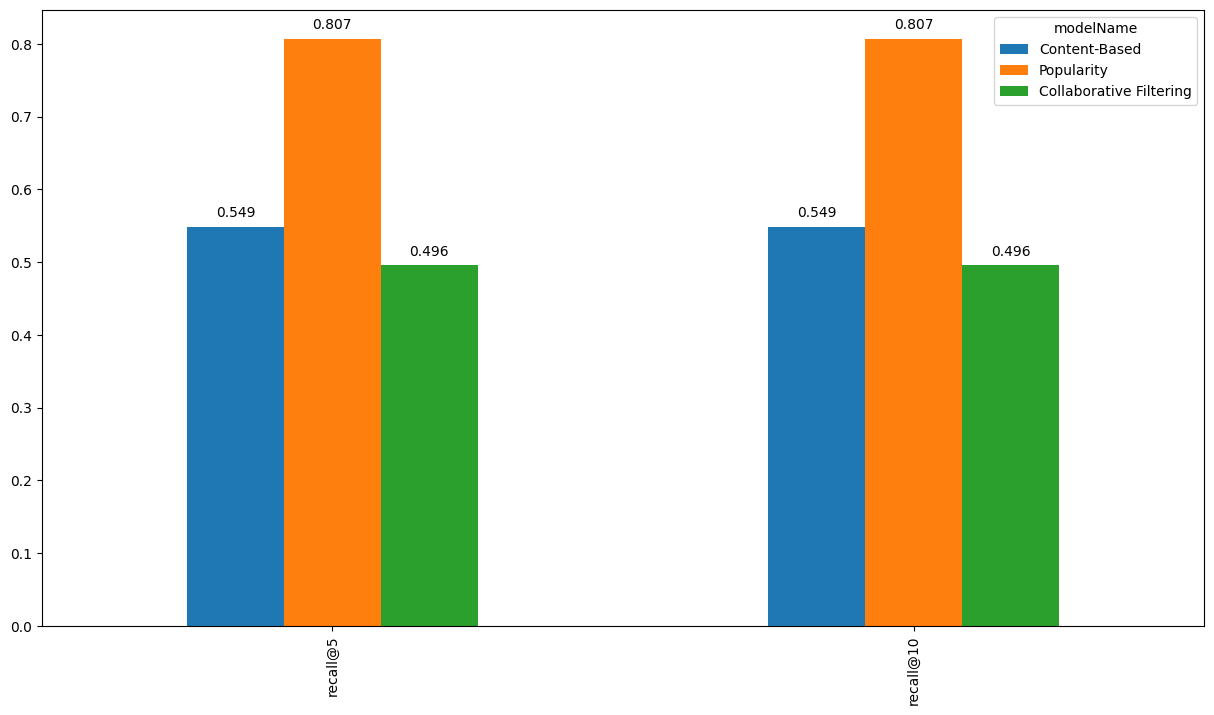

In [392]:
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

Nous avons comparé trois approches sur un échantillon CHAMELEON : Popularité, Content-Based (cosinus sur les embeddings d’articles) et Collaborative Filtering. La Popularité obtient le meilleur recall@K (~0,81), le Content-Based suit (~0,55) et le Collaborative Filtering est derrière (~0,50). Cela suggère que, dans un contexte de recommendation d'articles, la « sagesse des foules » est un excellent socle, tandis que le CF pâtit de la sparsité ; Le modèle Content-Based peut etre un excellent choix mais doit être affiné.

# Reduction de dimensions: PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

pca = PCA(n_components=128, random_state=42)
reduced_embeddings = pca.fit_transform(embeddings)

In [ ]:
reduced_embeddings.shape

(364047, 128)

In [ ]:
norm_reduced_embeddings = normalize(reduced_embeddings, axis=1)

In [ ]:
np.save(os.path.join(base_path, "norm_reduced_embeddings.npy"), norm_reduced_embeddings)